## Dataset Analysis
### 09/09/25

In [25]:
#### Load libs
from ase.db import connect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import annotations
import os, json, sqlite3, re, math
from functools import reduce
from pymatgen.core import Structure
from pymatgen.analysis.structure_matcher import StructureMatcher
from scipy.stats import pearsonr
from tqdm import tqdm
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.structure_matcher import StructureMatcher
from collections import defaultdict

# Set paths to databases
C2DB_PATH = "c2db.db"
MP2D_PATH = "2dmatpedia_final.db"
DB_PATHS = ["c2db.db", "2dmatpedia_final.db"]

## Distribution Analysis for C2DB 

In [3]:
# Path to the database file
db = connect(C2DB_PATH)

records = []
all_kv_keys, all_data_keys = set(), set()

# Connecting to the SQLite database
conn = sqlite3.connect(C2DB_PATH)

# Listing available tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Available tables in the database:\n", tables)

Available tables in the database:
                 name
0            systems
1    sqlite_sequence
2            species
3               keys
4    text_key_values
5  number_key_values
6        information


In [4]:
for row in db.select():
    # Basic fields guaranteed by ASE
    base = {
        "id": row.id,
        "formula": getattr(row, "formula", None),
        "natoms": getattr(row, "natoms", None),
        "calculator": getattr(row, "calculator", None),
        "pbc": getattr(row, "pbc", None),
        "user": getattr(row, "user", None),
        "mtime": getattr(row, "mtime", None),
        "ctime": getattr(row, "ctime", None),
        "key_value_pairs": None,   # just for reference
        "data_keys": None          # just for reference
    }
    # Key-value pairs and data (may contain many properties)
    kv = dict(getattr(row, "key_value_pairs", {}) or {})
    data = dict(getattr(row, "data", {}) or {})

    all_kv_keys |= set(kv.keys())
    all_data_keys |= set(data.keys())

    # Simple filter: keep only convertible scalars (avoids nested lists/arrays)
    def keep_scalar(x):
        return (
            x is None or
            isinstance(x, (str, int, float, bool, np.number))
        )

    kv_flat = {k: v for k, v in kv.items() if keep_scalar(v)}
    data_flat = {k: v for k, v in data.items() if keep_scalar(v)}

    rec = {**base, **kv_flat, **data_flat}
    rec["key_value_pairs"] = list(kv_flat.keys())
    rec["data_keys"] = list(data_flat.keys())
    records.append(rec)

df = pd.DataFrame.from_records(records)

print(f"Records read: {len(df)}")
print(f"Total columns in DataFrame: {len(df.columns)}")

Records read: 16905
Total columns in DataFrame: 93


In [5]:
# --- STEP 2 (robust version) ---
inf_tokens = {
    "Inf": np.inf, "-Inf": -np.inf, "inf": np.inf, "-inf": -np.inf,
    "+Inf": np.inf, "+inf": np.inf, "INf": np.inf, "InF": np.inf
}

def is_scalar_like(x):
    return (
        x is None or
        isinstance(x, (str, int, float, bool, np.number, np.bool_))
    )

def norm_inf_token(v):
    if isinstance(v, str):
        return inf_tokens.get(v.strip(), v)
    return v

cols_arraylike = []

for col in df.columns:
    s = df[col]
    # if the column has any non-scalar value (list/array/dict), skip it
    nn = s.dropna()
    if not nn.empty and nn.map(lambda x: not is_scalar_like(x)).any():
        cols_arraylike.append(col)
        continue

    if s.dtype == object:
        # normalize infinity tokens per element
        s = s.map(norm_inf_token)
        # try to convert to numeric when it makes sense
        coerced = pd.to_numeric(s, errors="coerce")
        if coerced.notna().mean() >= 0.2:   # heuristic
            df[col] = coerced
        else:
            df[col] = s

print("Columns ignored for containing list/array/dict:", cols_arraylike)

Columns ignored for containing list/array/dict: ['pbc', 'key_value_pairs', 'data_keys']


In [6]:
# === 3) Top 25 columns with the fewest nulls (most complete) ===
null_counts = df.isna().sum().sort_values()
print("\nTop 15 properties with the fewest nulls:")
top15_notnull = null_counts.head(25)
print(top15_notnull)


Top 15 properties with the fewest nulls:
id                          0
formula                     0
natoms                      0
calculator                  0
pbc                         0
user                        0
mtime                       0
ctime                       0
key_value_pairs             0
data_keys                   0
folder                      0
uid                         0
international               0
number                      0
has_inversion_symmetry      0
lgnum                       0
thickness                   0
layergroup                  0
hform                       0
dyn_stab                    0
ehull                       0
olduid                    116
label                     139
bravais_search            210
bravais_type              210
dtype: int64


In [7]:
# === 3) Top 25 columns with the fewest nulls (most complete) ===
null_counts = df.isna().sum().sort_values()
not_zero = null_counts[null_counts > 0]
print("\nTop 25 properties with the fewest nulls:")
top25_notnull = not_zero.head(25)
print(top25_notnull)


Top 25 properties with the fewest nulls:
olduid                 116
label                  139
bravais_search         210
bravais_type           210
is_magnetic           8204
dE_zy                 8204
spin_axis             8204
dE_zx                 8204
efermi                8206
gap_dir_nosoc         8206
evac                  8206
evacdiff              8206
gap_dir               8206
gap                   8206
dipz                  8206
minhessianeig         8756
alphaz_el            11553
alphax_el            11553
alphay_el            11553
cbm                  12338
vbm                  12338
plasmafrequency_x    12974
plasmafrequency_y    12974
emass_cbm            13241
emass_vbm            13241
dtype: int64


## Distribution Analysis for 2DMatPedia 


In [7]:
# =========================
# Utilities
# =========================
def is_scalar_like(x):
    return (
        x is None or
        isinstance(x, (str, int, float, bool, np.number, np.bool_))
    )

inf_tokens = {
    "Inf": np.inf, "-Inf": -np.inf, "inf": np.inf, "-inf": -np.inf,
    "+Inf": np.inf, "+inf": np.inf, "INf": np.inf, "InF": np.inf,
    "NaN": np.nan, "nan": np.nan
}
def norm_inf_token(v):
    if isinstance(v, str):
        return inf_tokens.get(v.strip(), v)
    return v

def normalize_df_inplace(df: pd.DataFrame):
    """Converts object columns to numeric when appropriate
    and handles 'Inf', '-Inf', etc. Without exploding columns with arrays/lists."""
    cols_arraylike = []
    for col in df.columns:
        s = df[col]
        nn = s.dropna()
        if not nn.empty and nn.map(lambda x: not is_scalar_like(x)).any():
            cols_arraylike.append(col)
            continue
        if s.dtype == object:
            s = s.map(norm_inf_token)
            coerced = pd.to_numeric(s, errors="coerce")
            if coerced.notna().mean() >= 0.2:
                df[col] = coerced
            else:
                df[col] = s
    return cols_arraylike

def first_existing(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

In [8]:
# =========================
# Loader 1: ASE .db
# =========================
def load_as_ase_db(path: str) -> pd.DataFrame:
    db = connect(path)
    records = []
    for row in db.select():
        base = {
            "id": getattr(row, "id", None),
            "formula": getattr(row, "formula", None),
            "natoms": getattr(row, "natoms", None),
            "calculator": getattr(row, "calculator", None),
            "pbc": getattr(row, "pbc", None),
            "mtime": getattr(row, "mtime", None),
            "ctime": getattr(row, "ctime", None),
        }
        kv = dict(getattr(row, "key_value_pairs", {}) or {})
        data = dict(getattr(row, "data", {}) or {})

        # keep only scalars (avoids arrays/cells)
        kv_flat = {k: v for k, v in kv.items() if is_scalar_like(v)}
        data_flat = {k: v for k, v in data.items() if is_scalar_like(v)}

        rec = {**base, **kv_flat, **data_flat}
        records.append(rec)
    return pd.DataFrame.from_records(records)

In [9]:
# =========================
# Loader 2: SQLite .db
# =========================
def load_as_sqlite_db(path: str) -> pd.DataFrame:
    con = sqlite3.connect(path)
    try:
        tables = pd.read_sql_query(
            "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';",
            con
        )["name"].tolist()
        if not tables:
            raise RuntimeError("No tables found in SQLite.")

        # Read all tables
        dfs = {}
        sizes = {}
        for t in tables:
            df_t = pd.read_sql_query(f"SELECT * FROM '{t}';", con)
            dfs[t] = df_t
            sizes[t] = len(df_t)

        # Try to find a common key to join (preference order)
        candidate_keys = ["material_id", "id", "entry_id", "mp_id", "uid", "structure_id"]
        common_key = None
        for key in candidate_keys:
            # present in at least two tables?
            if sum(int(key in df.columns) for df in dfs.values()) >= 2:
                common_key = key
                break

        if common_key:
            # join all tables that have the key
            to_merge = [df for df in dfs.values() if common_key in df.columns]
            df = reduce(lambda l, r: pd.merge(l, r, on=common_key, how="outer"), to_merge)
        else:
            # no common key: take the largest table as base
            main_table = max(sizes, key=sizes.get)
            df = dfs[main_table]

        return df
    finally:
        con.close()

In [10]:
# =========================
# Orchestration: tries ASE -> falls back to SQLite
# =========================
def load_2dmatpedia_db(path: str) -> pd.DataFrame:
    # Simple heuristic: if you can import ASE and open, use it; otherwise, SQLite
    try:
        from ase.db import connect  # noqa: F401
        # quick attempt to open as ASE
        df = load_as_ase_db(path)
        if not df.empty:
            print("[INFO] Loaded as ASE .db")
            return df
        # if empty, try SQLite
        print("[WARN] ASE returned empty; trying as SQLite…")
        return load_as_sqlite_db(path)
    except Exception as e:
        print(f"[WARN] Failed as ASE ({e}); trying as SQLite…")
        return load_as_sqlite_db(path)

[INFO] Loaded as ASE .db
Records read: 6351 | Columns: 32
Columns ignored for containing list/array/dict: ['pbc']

Top 15 properties with the fewest nulls (numeric only):
id                                0
natoms                            0
mtime                             0
ctime                             0
nelements                         0
sg_number                         0
bandgap                           0
total_magnetization               0
energy_vdw_per_atom               0
energy_per_atom                 195
decomposition_energy            196
exfoliation_energy_per_atom    1824
dtype: int64


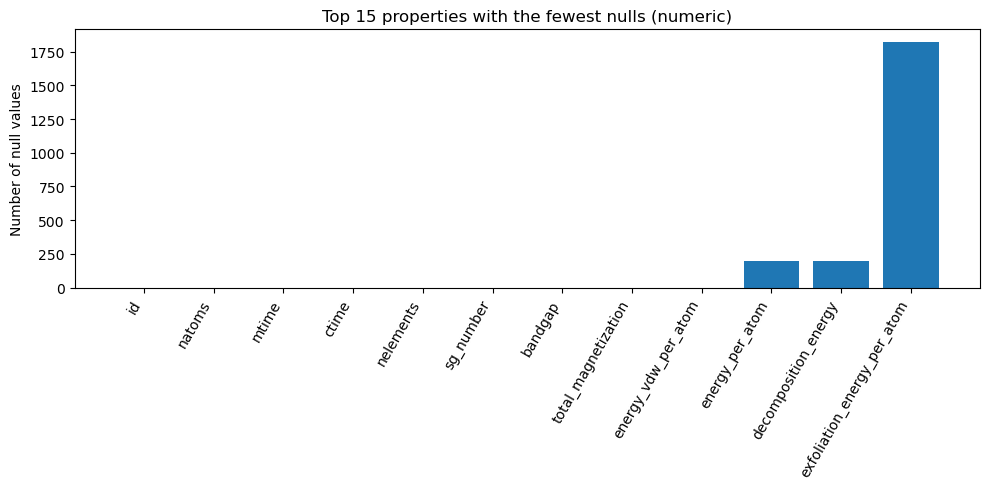

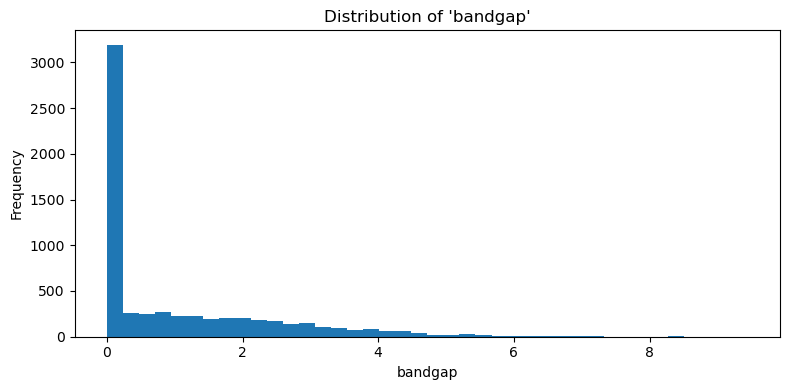

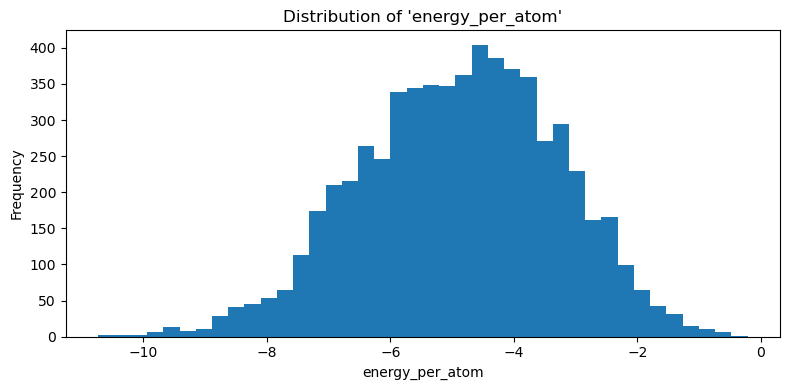

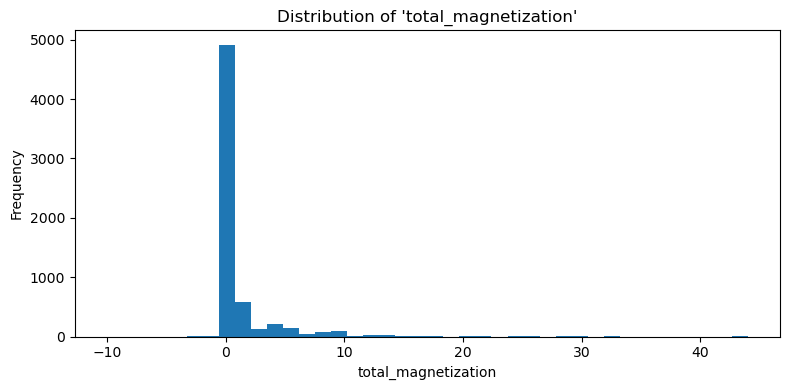

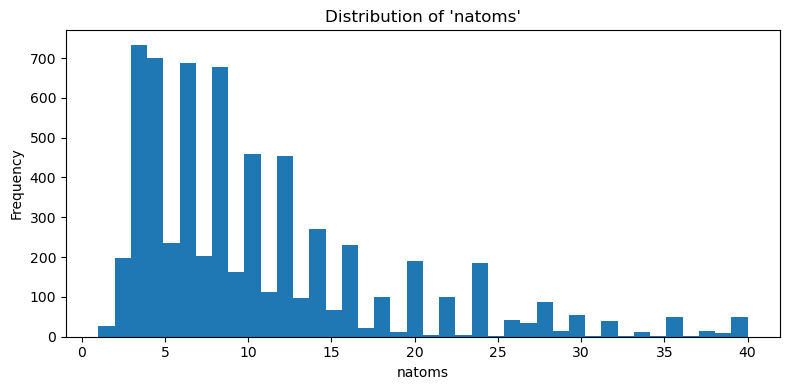


Sample of columns: ['id', 'formula', 'natoms', 'calculator', 'pbc', 'mtime', 'ctime', 'material_id', 'relative_id', 'source_id', 'creation_task_label', 'discovery_process', 'formula_pretty', 'formula_reduced_abc', 'formula_anonymous', 'chemsys', 'nelements', 'sg_number', 'sg_symbol', 'bandgap', 'total_magnetization', 'energy_per_atom', 'energy_vdw_per_atom', 'exfoliation_energy_per_atom', 'decomposition_energy', 'sg_crystal_system', 'sg_point_group', 'sg_hall', 'elements', 'created_at']


In [11]:
# =========================
# Execution
# =========================
if __name__ == "__main__":
    assert os.path.exists(MP2D_PATH), f"File not found: {MP2D_PATH}"
    df = load_2dmatpedia_db(MP2D_PATH)
    print(f"Records read: {len(df)} | Columns: {len(df.columns)}")

    # Normalization
    cols_arraylike = normalize_df_inplace(df)
    if cols_arraylike:
        print("Columns ignored for containing list/array/dict:", cols_arraylike)

    # Focus on numeric columns for metrics/histograms
    df_num = df.select_dtypes(include=[np.number])
    if df_num.empty:
        print("No numeric columns available after normalization.")
    else:
        # Top N columns with the fewest nulls
        N = 15
        null_counts = df_num.isna().sum().sort_values()
        top_notnull = null_counts.head(N)
        print(f"\nTop {N} properties with the fewest nulls (numeric only):")
        print(top_notnull)

        plt.figure(figsize=(10, 5))
        plt.bar(top_notnull.index.astype(str), top_notnull.values)
        plt.xticks(rotation=60, ha="right")
        plt.ylabel("Number of null values")
        plt.title(f"Top {N} properties with the fewest nulls (numeric)")
        plt.tight_layout()
        plt.show()

    # Histograms of key properties (with 2DMatPedia/C2DB synonyms)
    prop_synonyms = {
        "band_gap": [
            "band_gap", "bandgap", "gap", "Eg", "Egap", "E_g",
            "bandgap_pbe", "bandgap_lda"
        ],
        "energy": [
            "energy", "total_energy", "potential_energy",
            "energy_per_atom", "formation_energy_per_atom",
            "formation_energy", "e_form", "e_form_per_atom",
            "delta_e", "stability"
        ],
        "magmom": [
            "magmom", "tot_magmom", "magnetic_moment",
            "total_magnetization", "magnetization", "magmom_per_cell"
        ],
        "natoms": [
            "natoms", "n_atoms", "num_atoms", "N"
        ]
    }

    for label, candidates in prop_synonyms.items():
        col = first_existing(df.columns, candidates)
        if col is None:
            print(f"Did not find any column among {candidates}")
            continue

        s = df[col]
        if s.dtype == object:
            s = pd.to_numeric(s.map(norm_inf_token), errors="coerce")
        else:
            s = s.astype(float)

        s = s.dropna()
        if s.empty:
            print(f"Column '{col}' found, but no numeric data to plot.")
            continue

        plt.figure(figsize=(8, 4))
        plt.hist(s, bins=40)
        plt.title(f"Distribution of '{col}'")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    # Tip: list some columns
    print("\nSample of columns:", list(df.columns)[:30])

## Comparison between C2DB and 2DMatPedia

### Verify the number of common systems

In [29]:
OUTPUT_CSV = "robust_structural_matches.csv"

def load_structures_by_formula(db_path: str):
    """
    Reads an ASE DB and returns a dictionary mapping each formula
    to a list of (id, structure) tuples.
    """
    if not os.path.exists(db_path):
        print(f"WARNING: Database file not found: {db_path}")
        return {}

    db = connect(db_path)
    structures_map = defaultdict(list)
    
    print(f"Loading all structures from {db_path}...")
    for row in tqdm(db.select(), total=len(db)):
        try:
            # Using the raw formula for grouping
            formula = row.toatoms().get_chemical_formula(mode='hill', empirical=True)
            atoms = row.toatoms()
            # Convert to Pymatgen structure for later comparison
            structure = AseAtomsAdaptor.get_structure(atoms)
            # Store the database ID and the structure object
            structures_map[formula].append({'id': row.id, 'struct': structure})
        except Exception:
            continue
            
    return structures_map

# --- Main Logic ---
if __name__ == "__main__":
    # 1. Load all structures from both databases, grouped by formula
    c2db_structs = load_structures_by_formula(C2DB_PATH)
    mp2d_structs = load_structures_by_formula(MP2D_PATH)

    # Initialize the StructureMatcher
    # These tolerances can be adjusted if needed
    matcher = StructureMatcher(ltol=0.5, stol=0.5, angle_tol=50, primitive_cell=True)

    # Find formulas that are common to both databases
    common_formulas = set(c2db_structs.keys()) & set(mp2d_structs.keys())
    
    print(f"\nFound {len(common_formulas)} common formulas. Starting robust structural comparison...")

    found_matches = []

    # 2. For each common formula, compare all structures from C2DB against all from 2DMatPedia
    for formula in tqdm(common_formulas, desc="Comparing Formulas"):
        for c2_entry in c2db_structs[formula]:
            for mp2d_entry in mp2d_structs[formula]:
                try:
                    # The core of the robust comparison
                    if matcher.fit(c2_entry['struct'], mp2d_entry['struct']):
                        # If they match, save the pair of IDs
                        found_matches.append({
                            'formula': formula,
                            'c2db_id': c2_entry['id'],
                            'mp2d_id': mp2d_entry['id']
                        })
                        # Optional: break if you only want to find one match per C2DB structure
                        # break 
                except Exception:
                    # Some structures might still cause errors even with Pymatgen
                    continue
    
    # 3. Save the results to a CSV file
    if found_matches:
        matches_df = pd.DataFrame(found_matches)
        matches_df.to_csv(OUTPUT_CSV, index=False)
        print(f"\n--- Process Completed ---")
        print(f"Found {len(matches_df)} pairs of structurally identical materials.")
        print(f"Results saved to '{OUTPUT_CSV}'. This is your new definitive map of common structures.")
        print("\nSample of matched pairs:")
        print(matches_df.head())
    else:
        print("\n--- Process Completed ---")
        print("No structurally identical pairs were found with the current settings.")

Loading all structures from c2db.db...


100%|██████████| 16905/16905 [00:06<00:00, 2555.72it/s]


Loading all structures from 2dmatpedia_final.db...


100%|██████████| 6351/6351 [00:01<00:00, 3504.16it/s]



Found 1368 common formulas. Starting robust structural comparison...


Comparing Formulas: 100%|██████████| 1368/1368 [00:02<00:00, 594.19it/s]


--- Process Completed ---
No structurally identical pairs were found with the current settings.


### Verify geometry completeness

In [24]:
def check_database_geometries(db_path):
    """
    Checks an ASE database to count how many entries
    have valid geometry data.
    """
    if not os.path.exists(db_path):
        print(f"File not found: {db_path}\n")
        return

    print(f"Analyzing {db_path}...")
    
    db = connect(db_path)
    total_entries = 0
    with_geometry = 0

    for row in db.select():
        total_entries += 1
        
        try:
            # The most reliable way to check geometry is to try
            # to reconstruct the Atoms object.
            atoms = row.toatoms()
            
            # Check if the cell (lattice parameters) is not null or empty.
            # atoms.cell.any() checks if there is any non-zero value in the cell matrix.
            if atoms and hasattr(atoms, 'cell') and np.any(atoms.cell):
                with_geometry += 1
        except Exception:
            # If reconstruction fails, consider there is no geometry data.
            continue
            
    # Print the results for this database
    if total_entries > 0:
        percentage = (with_geometry / total_entries) * 100
        print(f"- Total entries: {total_entries}")
        print(f"- Entries with geometry data: {with_geometry} ({percentage:.2f}%)")
    else:
        print("- No entries found in the database.")
    
    print("-" * 20)

if __name__ == "__main__":
    for path in DB_PATHS:
        check_database_geometries(path)

Analyzing c2db.db...
- Total entries: 16905
- Entries with geometry data: 16905 (100.00%)
--------------------
Analyzing 2dmatpedia_final.db...
- Total entries: 6351
- Entries with geometry data: 6351 (100.00%)
--------------------
